In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch

from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

In [56]:
def gaussian(x, mu, sig):
    norm = math.sqrt(2 * math.pi) * sig
    return np.exp(-((x - mu) * (x - mu)) / (2 * sig * sig)) / norm

def construct_operators(N, alpha, beta):
    ST, SV = np.zeros((2, N, N)) # both are [N x N] matrices
    temp = np.arange(N)
    cutoff = N//1
    wall = int(N//1)
    for l in range(N):
        ST[:, l] += temp
        ST[l, :] -= np.transpose(temp)
        SV[:, l] += V(temp, N)
        SV[l, :] -= V(np.transpose(temp), N)
    
    ST *= alpha * ST
    SV *= beta

    ST = torch.tensor(ST) * 1
    SV = torch.tensor(SV) * 1

    K = (torch.complex(0*ST, ST) - torch.complex(0*SV, SV)).exp()

    return ST, SV, K

def normalize(psi):
    return psi / psi.norm()

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

### I have changed dx and dt to atomic phys natural units
### The numbers are now prop to hbar/(m_e c) and hbar/(m_e c^2), respectively
def init(hprms):
    constants = ObjectView(dict(
                             hbar=1/hprms.scale, m=hprms.m, 
                             numdx=int(hprms.spatial_density*hprms.scale**1.5),
                             numdt=int(hprms.time_density*hprms.scale**1.5), xrange=int(hprms.xrange), 
                             trange=int(hprms.trange), mom=hprms.momentum
                            ))
    
    dx = constants.xrange / constants.numdx  # scalar
    dt = constants.trange / constants.numdt  # scalar
    alpha = constants.m * (dx ** 2 / (2 * constants.hbar * dt))  # scalar
    beta = dt / constants.hbar  # scalar
    steps = constants.numdt // constants.trange
    interval = 2000 * hprms.vid_length / constants.numdt
    
    x = np.linspace(0, constants.xrange, constants.numdx)
    t = np.linspace(0, constants.trange, constants.numdt)

    ST, SV, K = construct_operators(constants.numdx, alpha, beta) # all three are [numdx x numdx]

    r0 = gaussian(x, constants.xrange/2, .025*constants.xrange)[:,None] # r0: [N x 1]
    r0[0, 0] = r0[-1, 0] = 0
    q0 = np.concatenate((np.cos(constants.mom * x)[:,None] * r0,
                         np.sin(constants.mom * x)[:,None] * r0), axis=1)
    q = torch.view_as_complex(torch.tensor(q0))
    
    
    return ObjectView(dict(x=x, t=t, ST=ST, SV=SV, K=K, q=q, interval=interval, steps=steps, dx=dx))

def simulate(q, K, steps=500):
    q = normalize(q)
    qs = [q.clone()]
    for i in range(steps):
        q = normalize(q @ K)
        qs.append(q.clone())
    return torch.stack(qs)

def make_video(x, qs, title, dx, path, interval=60, **kwargs):
    plt.title(title, fontweight="bold")
    plt.ylabel('Sqrt of Probability Density')
    fig = plt.gcf() ; fig.set_dpi(100) ; fig.set_size_inches(5, 3)
    camera = Camera(fig)
    
    for i, q in enumerate(qs):
        plt.plot(x, q.abs().detach(), 'b', label='Sqrt probability density')
        plt.axvline(torch.sum(torch.from_numpy(x)*q.abs().detach()).item()/torch.sum(q.abs().detach()).item(),
                    ls='-', color='firebrick')
        camera.snap()
    anim = camera.animate(blit=True, interval=interval, **kwargs)
    anim.save(path)
    plt.close()
    
    mp4 = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    HTML('<video width=400 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

def make_static(lft, lftnm, rgt, rgtnm, path):
    fig = plt.figure(figsize=(6, 3), dpi=300)
    ax1 = fig.add_subplot(121)
    ax1.imshow(lft) ; ax1.title.set_text(lftnm)
    ax2 = fig.add_subplot(122)
    ax2.imshow(rgt) ; ax2.title.set_text(rgtnm)
    plt.tight_layout()
    plt.show()
    if path != 'show':
        fig.savefig(path)
    plt.close()

# Pass a valid path if you want to save plots, or False to skip relevant computes
def produce_graphs(hprms, video=False, static_K='show', static_S='show'):
    trial_vars = init(hprms)
    if video:
        title = f'1D Gaussian wave packet, scale = {hprms.scale}'
        qs = simulate(trial_vars.q, trial_vars.K, steps=trial_vars.steps)
        make_video(trial_vars.x, qs, title, trial_vars.dx, path=video, interval=trial_vars.interval)        
    if static_K:
        make_static(trial_vars.K.real, 'K (real)', trial_vars.K.imag, 'K (imag)', path=static_K)
    if static_S:
        make_static(trial_vars.ST, 'ST', trial_vars.SV, 'SV', path=static_S)

4.0
4.090036010802894
4.180072021605763
4.27010803240861
4.3601440432114416
4.450180054014263
4.5402160648170655
4.6302520756198495
4.720288086422605
4.810324097225336
4.900360108028056
4.990396118830736
5.080432129631557
5.170468140280225
5.260504145728459
5.350540058929528
5.440575011044773
5.530603486492951
5.62060146578158
5.7104926277692005
5.800090904762097
5.88903331841474
5.976736235254499
6.062396388729319
6.145065024195528
6.223738842334704
6.297430294767582
6.3653865858704055
6.42702370391245
6.481756329782273
6.529380991824777
6.5701906614735135
6.604002709691455
6.630497947468918
6.6504920705263695
6.664815089589971
6.672664558223823
6.673972962094328
6.670011017159987
6.661591161675762
6.648231210217711
6.630349519710621
6.606717840813039
6.578855442408812
6.549356937663941
6.517405978627082
6.4812506132605785
6.439211777956304
6.394133204058818
6.349546559283176
6.307111943125055
6.2595740743120185
6.205282402601145
6.164236216063976
6.118655042183446
6.06592648839159
6.

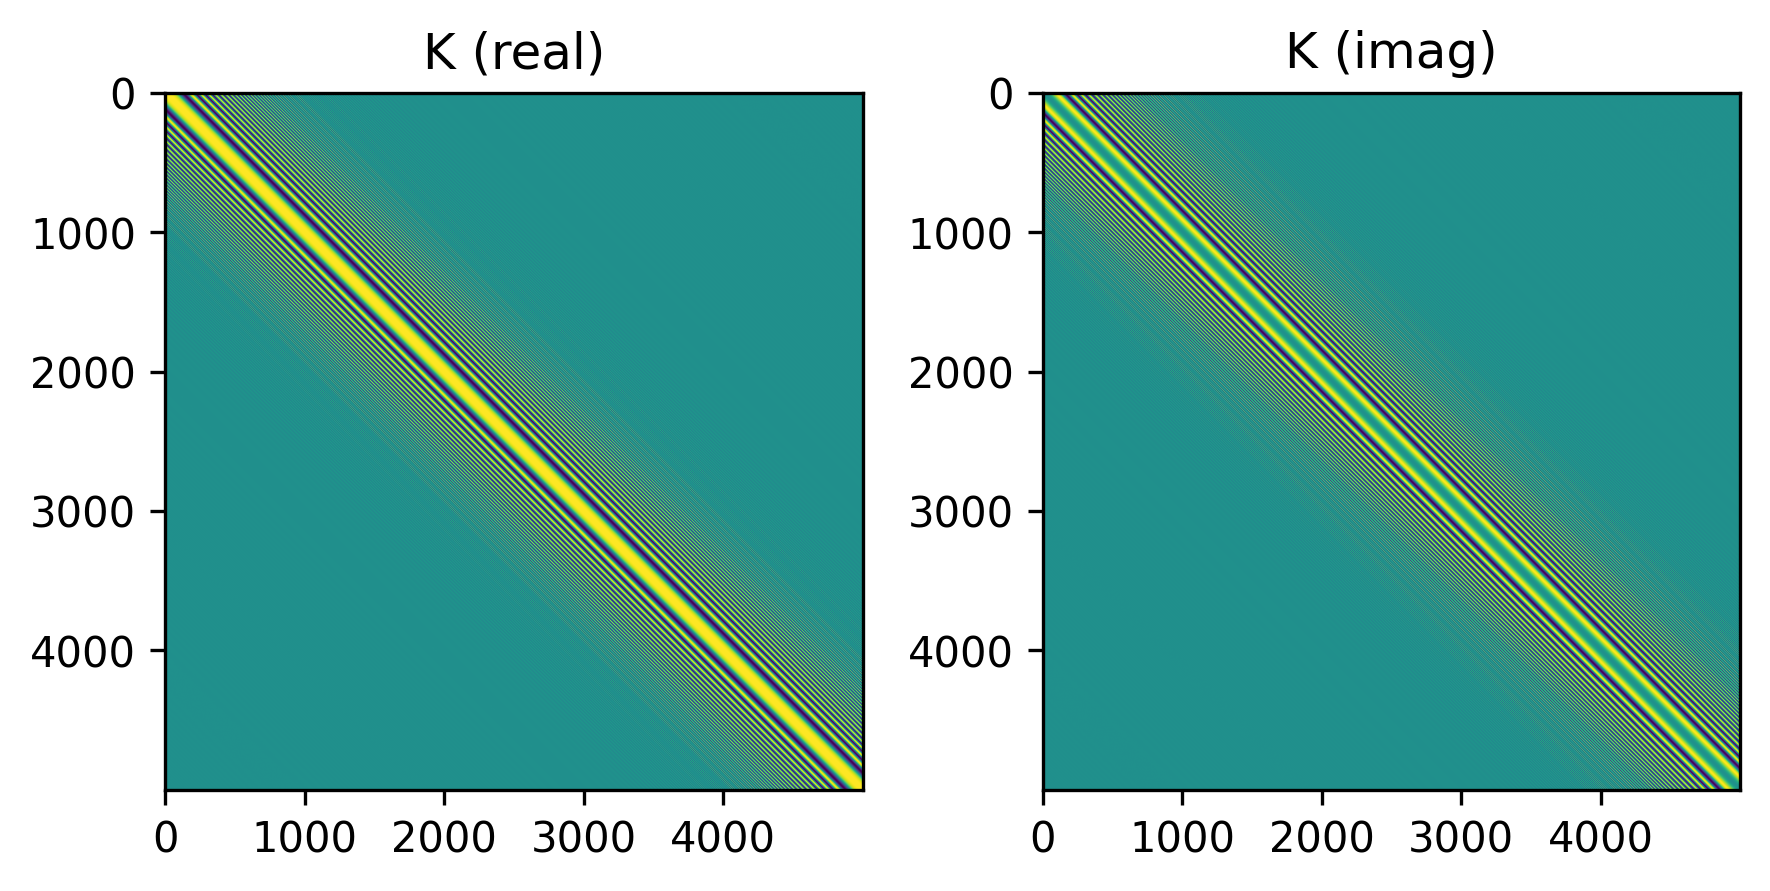

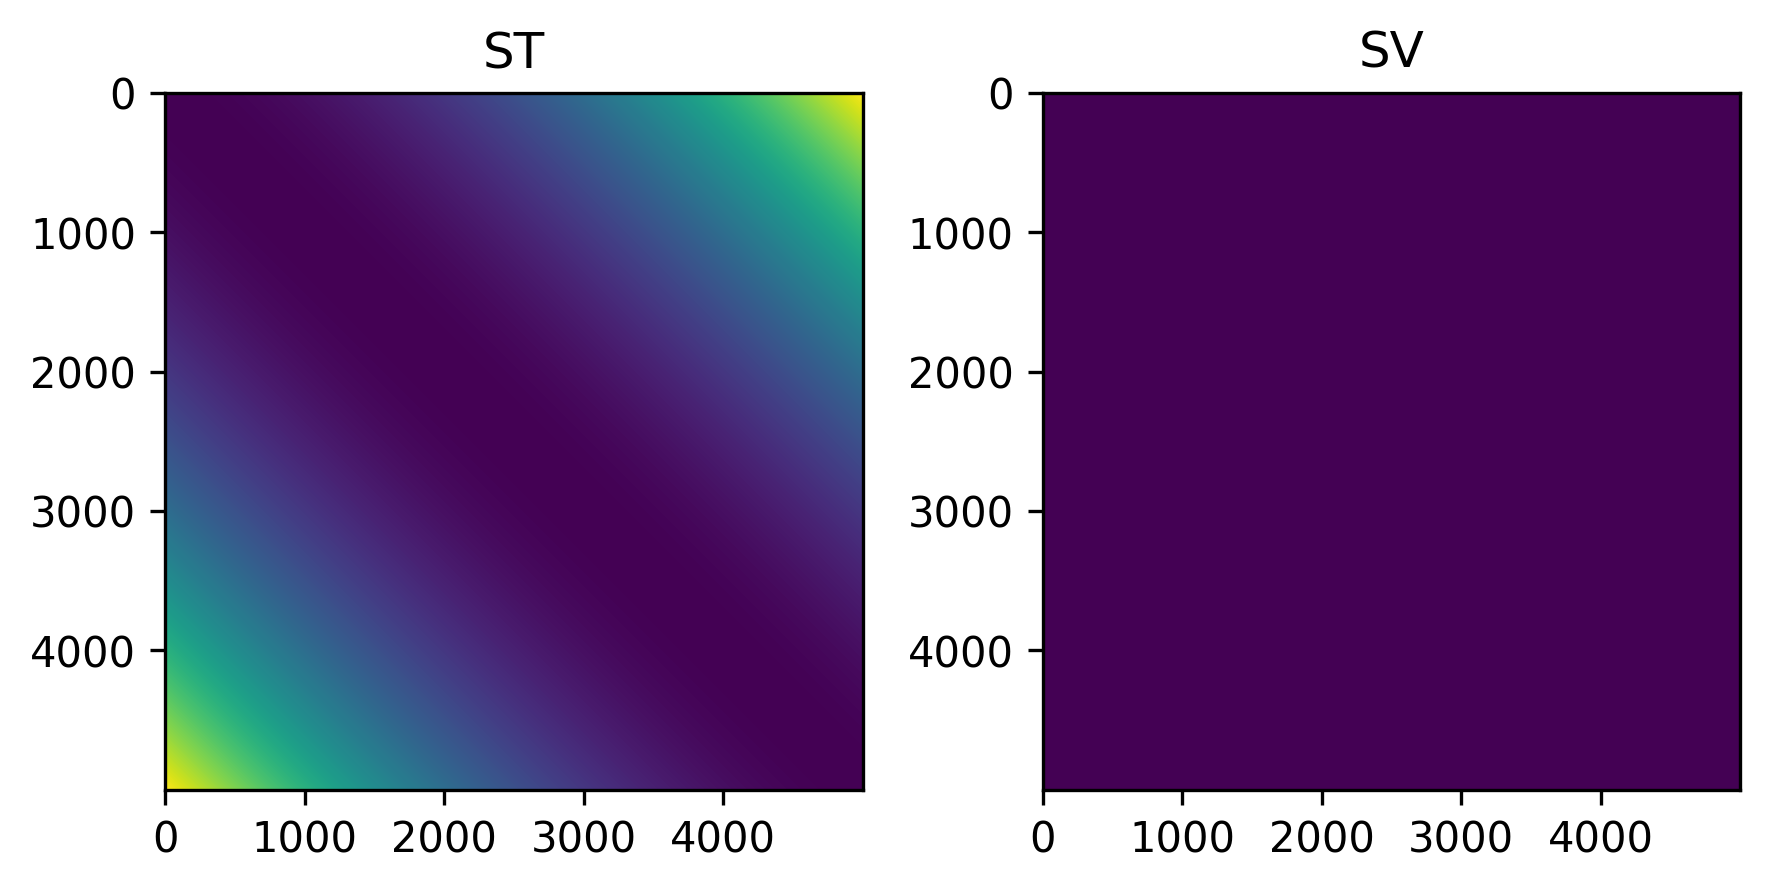

In [57]:
def V(x, N):
    div = 2; plat=int(N/2 - N/5)
    pot = np.linspace(-N/div, N/div, N) ** 2
    #pot[plat:int(N/2)] = pot[plat:int(N/2)] * 0
    #pot[int(N/2):-plat] = pot[int(N/2):-plat] * 0
    return pot*0

scales=[1]
for item in scales:
    hprms=ObjectView(dict(scale=item, m=1, spatial_density=5000,
                          time_density=500, xrange=8, trange=3,
                          momentum=15, vid_length=15))

    produce_graphs(hprms, video=f'quantum_plots/0V/{hprms.scale}scale.mp4',
                   static_S=f'quantum_plots/0V/S_{hprms.scale}scale.png', 
                   static_K=f'quantum_plots/0V/K_{hprms.scale}scale.png')